# Spaceship Titanic

- 데이터 전처리에 접중
    

In [1]:
import os
import sys
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf

2024-01-10 12:59:01.733801: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 12:59:01.759366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 12:59:01.759393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 12:59:01.759981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 12:59:01.764283: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices()

2024-01-10 12:59:02.807526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:02.831599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:02.831651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-01-10 12:59:02.852127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:02.852277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:02.852313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:03.830341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:59:03.830404: I external/local_xla/xla/stream_executor

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 793064673671401330
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9816768512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9868652997291174197
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

## Set envs

In [4]:
PATH_INPUT = './data/in/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
    )
except:
    print("NO GPU")

## Check Data

### Get Data

In [5]:
with ZipFile(PATH_INPUT + 'spaceship-titanic.zip') as f:
    print(f.namelist())

    df_train = pd.read_csv(BytesIO(f.read('train.csv')))
    df_test = pd.read_csv(BytesIO(f.read('test.csv')))
    df_sample = pd.read_csv(BytesIO(f.read('sample_submission.csv')))

['sample_submission.csv', 'test.csv', 'train.csv']


### Print Data

In [6]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [8]:
df_sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [9]:
df_train_origin = df_train.copy()

## Data Preprocessing

### About Data description
-> Split `Cabin` Data by "/"

In [10]:
df_train[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df_train['Cabin'].str.split("/", expand=True)
df_train.drop(columns=['Cabin'], inplace=True)
df_train['Cabin_Num'] = df_train['Cabin_Num'].astype(float)

### Check Data

In [11]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8494.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
 13  Cabin_Deck    8494 non-null   object 
 14  Cabin_Num     8494 non-null   float64
 15  Cabin_Side    8494 non-null   object 
dtypes: bool(1), float64(7), object(8)
memory usage: 1.0+ MB


In [13]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Cabin_Deck      199
Cabin_Num       199
Cabin_Side      199
dtype: int64

In [14]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'Cabin_Deck', 'Cabin_Num', 'Cabin_Side'],
      dtype='object')

### Data Chart

- `Transported` 분포

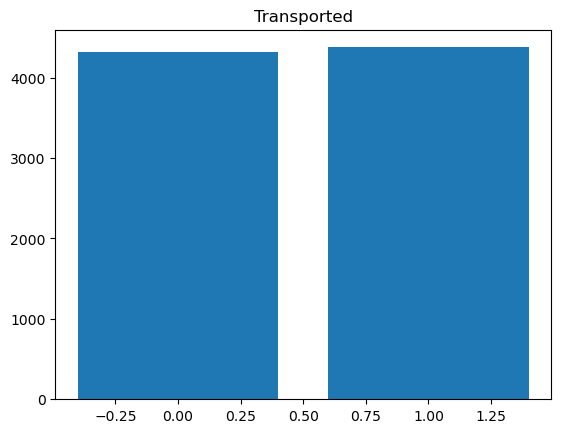

In [15]:
x = df_train['Transported'].unique()
y = [ len(df_train[df_train['Transported'] == i]) for i in x ]
plt.title('Transported')
plt.bar(x,y)
plt.show()

- `Age` - `Transported`

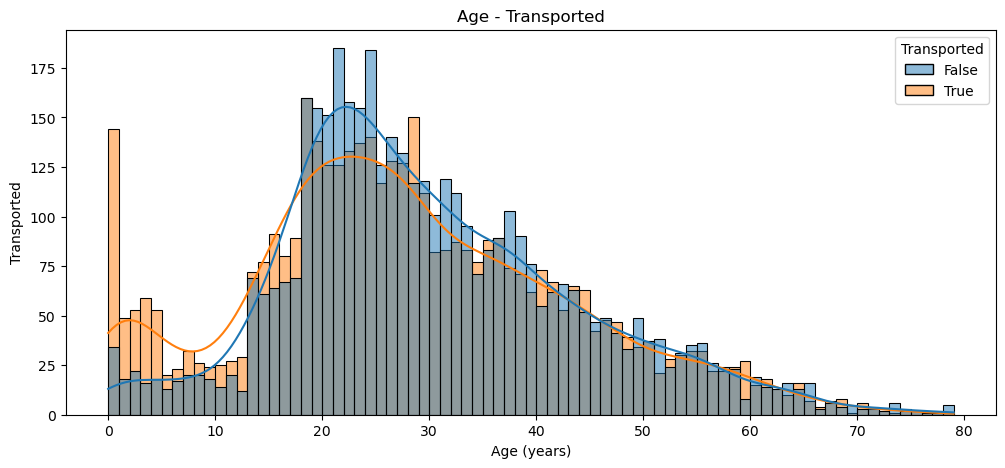

In [16]:
plt.figure(figsize=(12,5))
sns.histplot(data=df_train, x="Age", hue="Transported", binwidth=1, kde=True)

plt.title("Age - Transported")
plt.xlabel("Age (years)")
plt.ylabel("Transported")
plt.show()

- `RoomService` - `Transported`

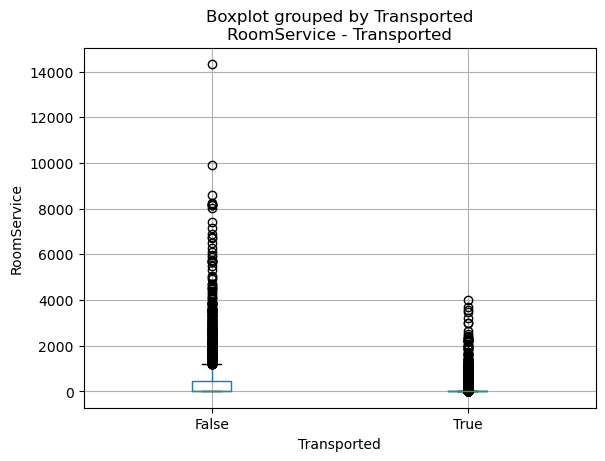

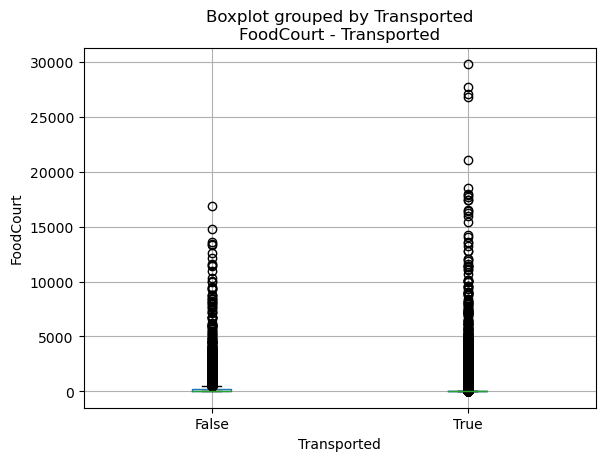

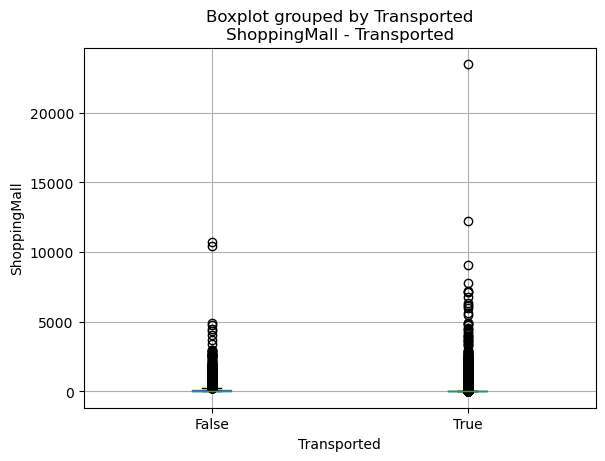

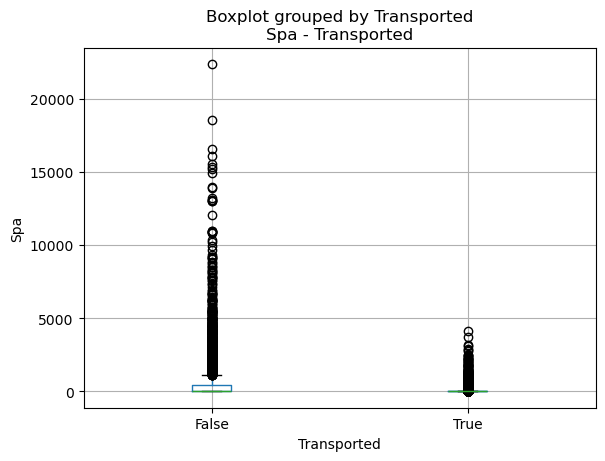

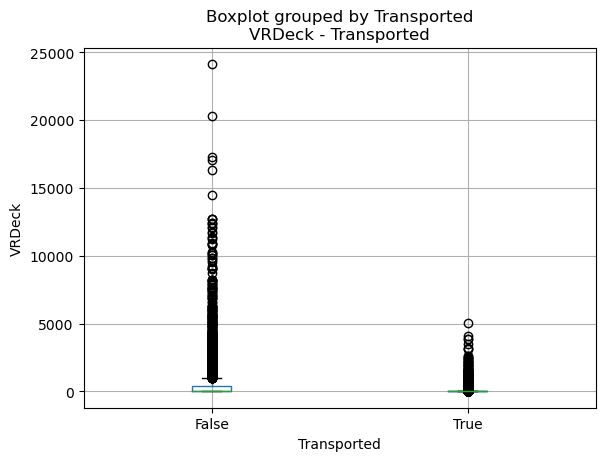

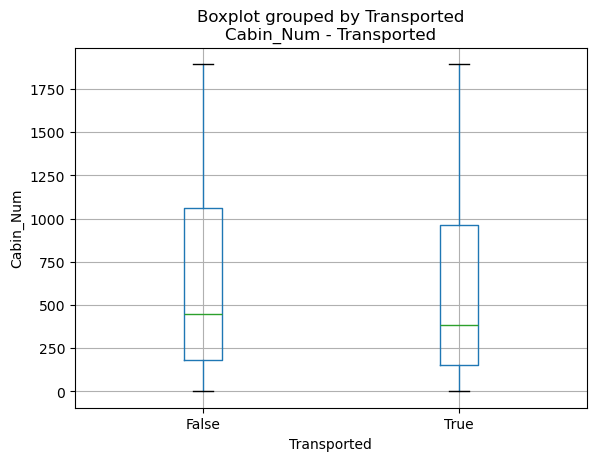

In [17]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']

for col in cols:
    dfplot = df_train.boxplot(col, by='Transported')
    dfplot.set_title(f"{col} - Transported")
    dfplot.set_ylabel(col)
    plt.show()

- `HomePlanet` - `Transported`

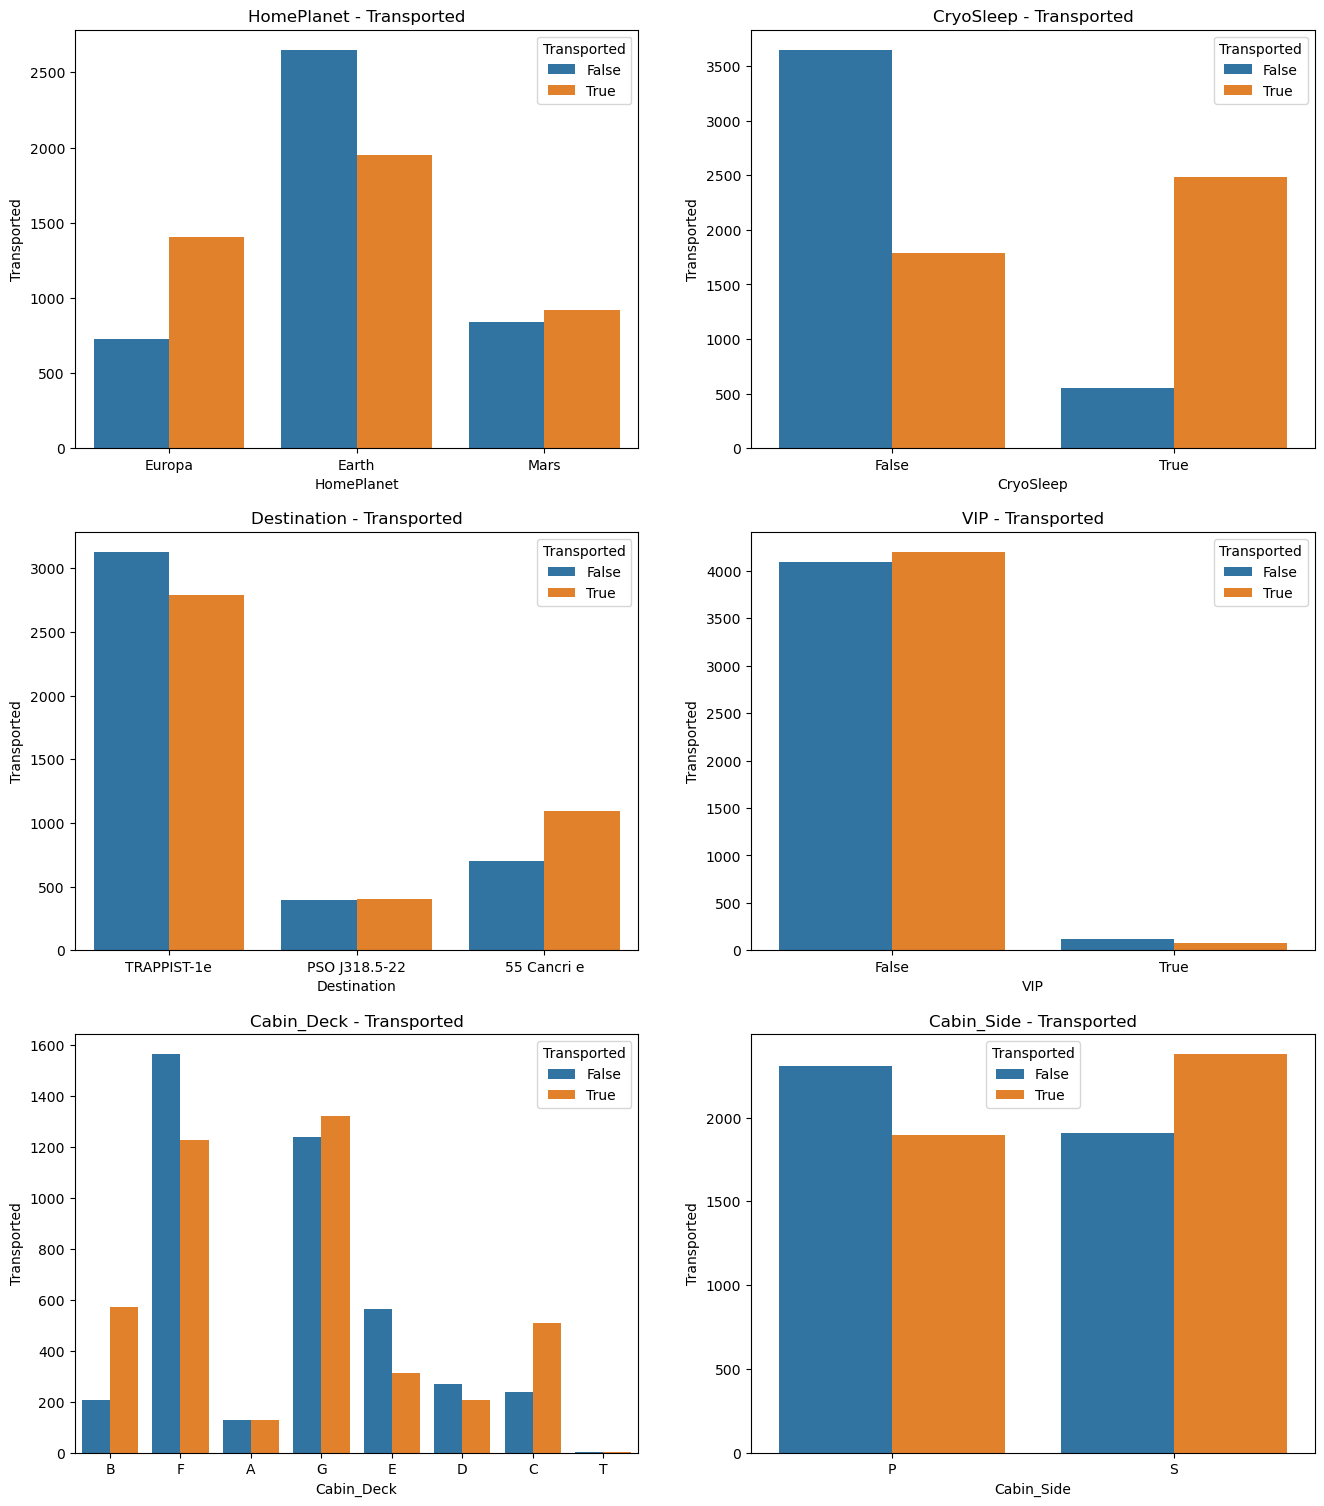

In [18]:
cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']

plot_idx = 1
plt.figure(figsize=(16,25))
for col in cols:
    plt.subplot(int(len(cols)/2)+1, 2, plot_idx)
    plt.title(f"{col} - Transported")
    sns.countplot(data=df_train, x=col, hue="Transported")

    plt.xlabel(col)
    plt.ylabel("Transported")
    plot_idx += 1

plt.show()

In [19]:
df_train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Num,Cabin_Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98.0,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499.0,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500.0,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608.0,S


In [20]:
df_train['Age'].mode(dropna=True)[0]

24.0

In [21]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Cabin_Deck      199
Cabin_Num       199
Cabin_Side      199
dtype: int64

### Preprocess

#### Null values

##### 1. `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`, `HomePlanet` - most frequency

In [22]:
## 1. Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, HomePlanet - most frequency
cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet']
for col in cols:
    most_freq = df_train[col].mode(dropna=True)[0]
    df_train[col].fillna(most_freq, inplace=True)

##### 2. `PassengerId`, `Name` - drop unnecessary columns

In [23]:
df_train.drop(columns=['PassengerId', 'Name'], inplace=True)

##### 3. `HomePlanet`, `Destination`, `Cabin_Deck`, `Cabin_Side` - Replace null value to "NoData"

In [24]:
cols = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side']
for col in cols:
    df_train[col].fillna("NoData", inplace=True)

##### 4. `CryoSleep`, `VIP`, `Cabin_Num` -> KNN Imputation

In [25]:
imputer = KNNImputer(n_neighbors=5)
cols = ['CryoSleep', 'VIP', 'Cabin_Num']
df_train[cols] = imputer.fit_transform(df_train[cols])
df_train['CryoSleep'] = df_train['CryoSleep'].astype(bool)
df_train['VIP'] = df_train['VIP'].astype(bool)

In [26]:
df_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98.0,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499.0,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500.0,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608.0,S


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Cabin_Deck    8693 non-null   object 
 12  Cabin_Num     8693 non-null   float64
 13  Cabin_Side    8693 non-null   object 
dtypes: bool(3), float64(7), object(4)
memory usage: 772.6+ KB


#### String values

##### 1. `HomePlanet`, `Destination` - Label Encoding

In [28]:
label_encoders = {}

cols = ['Destination', 'Cabin_Deck']
for col in cols:
    label_encoders[col] = LabelEncoder()
    label_encoders[col].fit(df_train[col])

    print(f"{col} LabelEncoder Classes")
    print(label_encoders[col].classes_)

    # apply dataframe
    df_train[col] = label_encoders[col].transform(df_train[col])

Destination LabelEncoder Classes
['55 Cancri e' 'NoData' 'PSO J318.5-22' 'TRAPPIST-1e']
Cabin_Deck LabelEncoder Classes
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'NoData' 'T']


In [29]:
label_encoders

{'Destination': LabelEncoder(), 'Cabin_Deck': LabelEncoder()}

##### 2. `HomePlanet` - One-hot Encoding

In [30]:
df_train = pd.get_dummies(df_train, columns=['HomePlanet'], dtype=bool)

### Definition Preprocess function

In [31]:
encoders = {}

def preprocessing(df):
    df = df.copy()

    # About Data description -> Split `Cabin` Data by "/"
    df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df['Cabin'].str.split("/", expand=True)
    df.drop(columns=['Cabin'], inplace=True)
    df['Cabin_Num'] = df['Cabin_Num'].astype(float)

    # Fill Null values
    ## 1. Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, HomePlanet - most frequency
    cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet']
    for col in cols:
        most_freq = df[col].mode(dropna=True)[0]
        df[col].fillna(most_freq, inplace=True)

    ## 2. Name - Delete columns
    cols = ['Name']
    df.drop(columns=cols, inplace=True)

    ## 3. HomePlanet, Destination, Cabin_Deck, Cabin_Side - Replace null value to "NoData"
    cols = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side']
    for col in cols:
        df[col].fillna("NoData", inplace=True)

    ## 4. CryoSleep, VIP, Cabin_Num - KNN Imputation
    cols = ['CryoSleep', 'VIP', 'Cabin_Num']
    imputer = KNNImputer(n_neighbors=5)
    df[cols] = imputer.fit_transform(df[cols])
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['VIP'] = df['VIP'].astype(bool)

    # Preprocess String values
    ## 1. `Destination`, 'Cabin_Deck', 'Cabin_Side' - LabelEncoding
    cols = ['Destination', 'Cabin_Deck', 'Cabin_Side']
    for col in cols:
        if col not in encoders.keys():
            encoders[col] = LabelEncoder()
        encoders[col].fit(df[col])

        print(f"{col} LabelEncoder Classes")
        print(encoders[col].classes_)

        # apply dataframe
        df[col] = encoders[col].transform(df[col])

    ## 2. `HomePlanet` - OnehotEncoding
    df = pd.get_dummies(df, columns=['HomePlanet'], dtype=bool)

    return df

In [32]:
df_train = df_train_origin.copy()

In [33]:
df_train = preprocessing(df_train)
df_test = preprocessing(df_test)

Destination LabelEncoder Classes
['55 Cancri e' 'NoData' 'PSO J318.5-22' 'TRAPPIST-1e']
Cabin_Deck LabelEncoder Classes
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'NoData' 'T']
Cabin_Side LabelEncoder Classes
['NoData' 'P' 'S']
Destination LabelEncoder Classes
['55 Cancri e' 'NoData' 'PSO J318.5-22' 'TRAPPIST-1e']
Cabin_Deck LabelEncoder Classes
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'NoData' 'T']
Cabin_Side LabelEncoder Classes
['NoData' 'P' 'S']


In [34]:
df_train

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Num,Cabin_Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,3,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0.0,1,False,True,False
1,0002_01,False,3,24.0,False,109.0,9.0,25.0,549.0,44.0,True,5,0.0,2,True,False,False
2,0003_01,False,3,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0.0,2,False,True,False
3,0003_02,False,3,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0.0,2,False,True,False
4,0004_01,False,3,16.0,False,303.0,70.0,151.0,565.0,2.0,True,5,1.0,2,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,0,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,0,98.0,1,False,True,False
8689,9278_01,True,2,18.0,False,0.0,0.0,0.0,0.0,0.0,False,6,1499.0,2,True,False,False
8690,9279_01,False,3,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,6,1500.0,2,True,False,False
8691,9280_01,False,0,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,4,608.0,2,False,True,False


In [35]:
df_test

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0013_01,True,3,27.0,False,0.0,0.0,0.0,0.0,0.0,6,3.0,2,True,False,False
1,0018_01,False,3,19.0,False,0.0,9.0,0.0,2823.0,0.0,5,4.0,2,True,False,False
2,0019_01,True,0,31.0,False,0.0,0.0,0.0,0.0,0.0,2,0.0,2,False,True,False
3,0021_01,False,3,38.0,False,0.0,6652.0,0.0,181.0,585.0,2,1.0,2,False,True,False
4,0023_01,False,3,20.0,False,10.0,0.0,635.0,0.0,0.0,5,5.0,2,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,3,34.0,False,0.0,0.0,0.0,0.0,0.0,6,1496.0,2,True,False,False
4273,9269_01,False,3,42.0,False,0.0,847.0,17.0,10.0,144.0,7,889.0,0,True,False,False
4274,9271_01,True,0,18.0,False,0.0,0.0,0.0,0.0,0.0,3,296.0,1,False,False,True
4275,9273_01,False,1,18.0,False,0.0,2680.0,0.0,0.0,523.0,3,297.0,1,False,True,False


## Save dataframe to csv

In [36]:
df_train.to_csv("./data/out/preprocessed_data/train.csv", index=False)
df_test.to_csv("./data/out/preprocessed_data/test.csv", index=False)

In [37]:
cols = ['CryoSleep', 'VIP', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']
df_train[cols] = df_train[cols].astype(int)
df_test[[i for i in cols if i != 'Transported']] = df_test[[i for i in cols if i != 'Transported']].astype(int)

In [38]:
df_train.to_csv("./data/out/preprocessed_data/train_int.csv", index=False)
df_test.to_csv("./data/out/preprocessed_data/test_int.csv", index=False)